# Cornershop's Data Science Test

## Dev: Mateus Broilo
mateus.brilo90@gmail.com

* Objectives: Production

# Summary

* Initials
    * Loading Libraries and Packages
    * Configurations
    * Global Variables
    * Function's Definition
        * Class of Preprocessed Functions
* Loading data
    * Dataset to be predicted 
* Preprocess
    * Missing Values
    * Feature Engineering
    * Selecting Resources
    * Group and Aggregate
    * Encoding
    * Importing Outlier Dictionary
* Model
    * Feature Set 4
    * Load Champion Model
    * Predicted Results
* Saving Predictions   

# Initials
* Loading Libraries and Packages
* Configuration
* Global Variables
* Function's Definition
    * Class of Preprocessed Functions

## Loading Libraries and Packages

In [1]:
# general
import warnings
import time
import gc

#data
import pandas as pd
import numpy as np
from datetime import (datetime, date)
import geopy.distance

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model
import joblib

In [2]:
ls ..\data\

 O volume na unidade C nÃ£o tem nome.
 O NÃºmero de SÃ©rie do Volume Ã© 1210-43E2

 Pasta de C:\Users\mbroilo\Documents\Arbeit\Personal\projects\cornershop\data

01/04/2022  20:54    <DIR>          .
03/04/2022  18:00    <DIR>          ..
29/03/2022  20:02        64.304.021 20220329_merged_full.csv
29/03/2022  20:02        12.563.082 20220329_merged_predict.csv
29/03/2022  20:03        51.741.160 20220329_merged_train_test.csv
01/04/2022  20:49         1.125.788 20220331_prep_20220329_merged_train_test.csv
               4 arquivo(s)    129.734.051 bytes
               2 pasta(s)   141.726.973.952 bytes disponÃ­veis


In [3]:
ls ..\analysis\

O sistema nÃ£o pode encontrar o arquivo especificado.


## Configurations

In [4]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 12, 
    'axes.titlesize': 24, 'xtick.labelsize': 14, 'ytick.labelsize': 12}

sns.set(rc=rc)
sns.set_palette("Set2")
sns.set_style("darkgrid")#sns.set_style("whitegrid")

## Global Variables

In [5]:
PATH_DATA = "../data/"
PATH_ANALYSIS = "../analysis/"
DATASET = "20220329_merged_predict.csv"
MODEL = '20220403_set4_XGBRegressor.sav'
OUTLIER_HIGH = "20220401_outlier_dict_high.txt"
OUTLIER_LOW = "20220401_outlier_dict_low.txt"
DATE = time.strftime("%Y%m%d")

## Function's Definition

### Class of Preprocessed Functions

In [6]:
class preprocess:
    
    # Replace Missing Values
    def replaceNull(df, col, change):
        """
        Describe the function!
        """
        df[col] = df[col].replace(np.nan, change)

    # Expand dates, create day of the week column and transform time to pure number
    def dateTimeConverter(dataset, col):
        """
        Describe the function!
        """
        day_of_week = list(pd.to_datetime(dataset[col], format='%Y-%m-%d').dt.dayofweek)
        dataset['day_of_week'] = day_of_week
        dataset[[col+'_DATE', col+'_HOUR']] = dataset[col].str.split(" ", expand=True)
        dataset[[col+'_HOUR', col+'_HOUR2']] = dataset[col+'_HOUR'].str.split("+", expand=True)
        dataset[[col+'_HH', col+'_MIN', col+'_SEC']] = dataset[col+'_HOUR'].str.split(":", expand=True)
        dataset['pure_time'] = dataset[col+'_HH'].astype(int) + (dataset[col+'_MIN'].astype(int) / 60) + (dataset[col+'_SEC'].astype(float) / 3600)
        
        dataset['day_of_week'] = dataset['day_of_week'].map(
            {
                0:'monday',
                1:'tuesday',
                2:'wednesday',
                3:'thursday',
                4:'friday',
                5:'saturday',
                6:'sunday'
            }
        )
        del dataset[col+'_HOUR2'], dataset[col+'_HH'], dataset[col+'_MIN'], dataset[col+'_SEC']

    # Calculate the distance between the deliver and the branch location
    def calculateDistance(dataset, latX, lngX, latY, lngY):
        """
        Describe the function!
        """
        coordsX = list(zip(dataset[latX], dataset[latX]))
        coordsY = list(zip(dataset[latY], dataset[latY]))

        dataset['coordsX'] = coordsX
        dataset['coordsY'] = coordsY
        dist = []

        for i in range(len(dataset)):
            distCalc = geopy.distance.distance(coordsX[i], coordsY[i]).km
            dist.append(distCalc)

        dataset['distance'] = dist

    # Calculate number of type of itens, weight and distinct itens per order
    def calculateItem(dataset, colUnit, colQuantity):
        """
        Describe the function!
        """
        no_item = []
        weight = []

        for i in range(len(dataset)):
            if dataset[colUnit][i] == 'UN':
                no_item.append(dataset[colQuantity][i])
                weight.append(0)
            elif dataset[colUnit][i] == 'KG':
                no_item.append(1)
                weight.append(dataset[colQuantity][i])
            else:
                no_item.append(np.nan)
                weight.append(np.nan)

        dataset['no_item'] = no_item
        dataset['weight'] = weight
        dataset['item'] = 1

    # Freeze Outliers in the corresponding listed values
    def getOutliers(dataset, file, ifHigh=True):
        """
        This function imports the outlier dictionary and apply it
        freezing values in a given dataset.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            file (json): Dictionary containing the outliers entries.
            ifHigh (boolean): If True then freeze above percentile, else freeze below.

        Returns:
            dataset (object/spreadsheet): With freezed outlier values.
        """   
        with open(file, 'r') as convert_file: 
            outlier = json.load(convert_file)

        for key in outlier:
            if ifHigh:
                dataset.loc[dataset[key] > outlier[key], key] = outlier[key]
                print(f"Column: {key}.max() = {outlier[key]}")
            else:
                dataset.loc[dataset[key] < outlier[key], key] = outlier[key]
                print(f"Column: {key}.min() = {outlier[key]}")

# Loading Data
* Dataset to be predicted

## Dataset to be predicted

In [7]:
df = pd.read_csv(PATH_DATA + DATASET, sep=',' )
print(df.shape)
df.head()

(40197, 19)


,order_id,lat_order,lng_order,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,seniority,found_rate,picking_speed,accepted_rate,rating,store_id,lat_storebranch,lng_storebranch,product_id,quantity,buy_unit
0,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,d2a7c010a3c78a3199cd79623a4be51e,5.0,UN
1,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,6d416af51a52cc688f4898eb199d49bc,5.0,UN
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,81cc6dc9a2924e1657015db4bfb2f340,1.0,UN
3,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,d0fd09285ad305f0513c784e1774f05c,2.0,UN
4,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,e89201074287fe0f9d85b00a48361762,5.0,UN


# Preprocess
* Missing Values
* Feature Engineering
* Selecting Resources
* Group and Aggregate
* Encoding
* Importing Outlier Dictionary

## Missing Values

In [8]:
# found_rate
preprocess.replaceNull(df, 'found_rate', df.groupby(by='order_id').median()['found_rate'].median())

# accepted_rate
preprocess.replaceNull(df, 'accepted_rate', df.groupby(by='order_id').median()['accepted_rate'].median())

# rating
preprocess.replaceNull(df, 'rating', df.groupby(by='order_id').median()['rating'].median())

# quantity
preprocess.replaceNull(df, 'quantity', df['quantity'].median())

## Feature Engineering

In [9]:
# Creating the resources: day_of_week and pure_time
preprocess.dateTimeConverter(df, 'promised_time')

# Creating the resource: distance
preprocess.calculateDistance(df, 'lat_order', 'lng_order', 'lat_storebranch', 'lng_storebranch')

# Creating the resources: number of itens, weight and distinct items per order
preprocess.calculateItem(df, 'buy_unit', 'quantity')

## Selecting Resources

In [10]:
selected = [
'order_id', #-> index!
'on_demand',
'seniority',
'found_rate',
'picking_speed',
'accepted_rate',
'rating',
'quantity',
'item',
'day_of_week',
'pure_time',
'distance',
'no_item'
]

## Group and Aggregate

In [11]:
df = df[selected].groupby(by=[
    'order_id',
    'seniority',
    'on_demand',
    'day_of_week'
], as_index=False).agg(
    {
        'pure_time':['mean'],
        'found_rate':['mean'],
        'picking_speed':['mean'],
        'accepted_rate':['mean'],
        'rating':['mean'],
        'distance':['mean'],
        'no_item':['sum'],
        'quantity':['sum'],
        'item':['sum']
    }
).copy()

df.columns = df.columns.droplevel(1)
df.set_index('order_id', inplace=True)
df

,seniority,on_demand,day_of_week,pure_time,found_rate,picking_speed,accepted_rate,rating,distance,no_item,quantity,item
order_id,,,,,,,,,,,,
002dbea77302f2d301a6bb2b01b94876,50e13ee63f086c2fe84229348bc91b5b,False,saturday,15.000000,0.8080,2.58,0.84,4.60,1.796106,1.0,1.000,1
0063a42f7c2e03b6471f352e9f0043f1,41dc7c9e385c4d2b6c1f7836973951bf,False,saturday,19.000000,0.8549,1.74,0.92,4.84,2.452761,60.0,62.310,40
00888238b55dd6feec6c7acb50e3570b,50e13ee63f086c2fe84229348bc91b5b,False,saturday,14.000000,0.8609,2.07,1.00,4.80,4.142399,38.0,37.593,25
00b2105a5bdcf5a556dffeada72353cb,41dc7c9e385c4d2b6c1f7836973951bf,False,saturday,20.000000,0.8468,1.75,0.96,4.92,0.477921,15.0,14.700,13
011e4d649c1ef9adc6f8c27cf0f7cf97,6c90661e6d2c7579f5ce337c3391dbb9,False,saturday,20.000000,0.8487,1.88,0.96,4.68,0.643522,28.0,27.644,14
...,...,...,...,...,...,...,...,...,...,...,...,...
ff56ea11c8a56227a2d7ee8102bd373e,50e13ee63f086c2fe84229348bc91b5b,False,saturday,1.000000,0.8131,2.62,1.00,4.76,5.670170,29.0,29.000,11
ff5ac72b76d64456c8430eaf967e9ba0,6c90661e6d2c7579f5ce337c3391dbb9,True,saturday,13.783333,0.8389,1.21,0.96,4.72,2.595498,51.0,50.300,24
ff5eb3121269e9350c9e1de083e5b3db,50e13ee63f086c2fe84229348bc91b5b,False,saturday,17.000000,0.8267,2.94,0.84,4.87,3.904646,14.0,14.500,5


## Encoding

In [12]:
df = pd.get_dummies(df, columns = ['seniority'])
print(df.shape)
df.head()

(2000, 15)


,on_demand,day_of_week,pure_time,found_rate,picking_speed,accepted_rate,rating,distance,no_item,quantity,item,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f
order_id,,,,,,,,,,,,,,,
002dbea77302f2d301a6bb2b01b94876,False,saturday,15.0,0.8080,2.58,0.84,4.60,1.796106,1.0,1.000,1,0,1,0,0
0063a42f7c2e03b6471f352e9f0043f1,False,saturday,19.0,0.8549,1.74,0.92,4.84,2.452761,60.0,62.310,40,1,0,0,0
00888238b55dd6feec6c7acb50e3570b,False,saturday,14.0,0.8609,2.07,1.00,4.80,4.142399,38.0,37.593,25,0,1,0,0
00b2105a5bdcf5a556dffeada72353cb,False,saturday,20.0,0.8468,1.75,0.96,4.92,0.477921,15.0,14.700,13,1,0,0,0
011e4d649c1ef9adc6f8c27cf0f7cf97,False,saturday,20.0,0.8487,1.88,0.96,4.68,0.643522,28.0,27.644,14,0,0,1,0


## Importing Outlier Dictionary

In [13]:
print(preprocess.getOutliers.__doc__)


        This function imports the outlier dictionary and apply it
        freezing values in a given dataset.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            file (json): Dictionary containing the outliers entries.
            ifHigh (boolean): If True then freeze above percentile, else freeze below.

        Returns:
            dataset (object/spreadsheet): With freezed outlier values.
        


In [14]:
preprocess.getOutliers(df, OUTLIER_HIGH, ifHigh=True)

Column: pure_time.max() = 20.666666666666668


In [15]:
preprocess.getOutliers(df, OUTLIER_LOW, ifHigh=False)

Column: pure_time.min() = 15.0


# Loading Model
* Feature Set 4
* Load Champion Model
* Predicted Results

## Feature Set 4

In [16]:
features_set4 = [
    'seniority_41dc7c9e385c4d2b6c1f7836973951bf',
    'seniority_50e13ee63f086c2fe84229348bc91b5b',
    'seniority_6c90661e6d2c7579f5ce337c3391dbb9',
    'seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f',
    'on_demand',
    'pure_time',
    'found_rate',
    'picking_speed',
    'accepted_rate',
    'rating',
    'distance',
    'no_item',
    'quantity',
    'item'
]

In [17]:
df = df[features_set4].copy()
print(df.shape)
df.head()

(2000, 14)


,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f,on_demand,pure_time,found_rate,picking_speed,accepted_rate,rating,distance,no_item,quantity,item
order_id,,,,,,,,,,,,,,
002dbea77302f2d301a6bb2b01b94876,0,1,0,0,False,15.0,0.8080,2.58,0.84,4.60,1.796106,1.0,1.000,1
0063a42f7c2e03b6471f352e9f0043f1,1,0,0,0,False,19.0,0.8549,1.74,0.92,4.84,2.452761,60.0,62.310,40
00888238b55dd6feec6c7acb50e3570b,0,1,0,0,False,15.0,0.8609,2.07,1.00,4.80,4.142399,38.0,37.593,25
00b2105a5bdcf5a556dffeada72353cb,1,0,0,0,False,20.0,0.8468,1.75,0.96,4.92,0.477921,15.0,14.700,13
011e4d649c1ef9adc6f8c27cf0f7cf97,0,0,1,0,False,20.0,0.8487,1.88,0.96,4.68,0.643522,28.0,27.644,14


## Load Champion Model

In [18]:
model = joblib.load(MODEL)
y_hat = model.predict(df)

In [19]:
y_hat

array([ 48.153957, 120.69338 , 106.421616, ...,  77.04032 ,  84.79782 ,
       117.274   ], dtype=float32)

In [20]:
ls ..\mvp\

 O volume na unidade C nÃ£o tem nome.
 O NÃºmero de SÃ©rie do Volume Ã© 1210-43E2

 Pasta de C:\Users\mbroilo\Documents\Arbeit\Personal\projects\cornershop\mvp

03/04/2022  18:40    <DIR>          .
03/04/2022  18:00    <DIR>          ..
03/04/2022  18:01    <DIR>          .ipynb_checkpoints
03/04/2022  18:33    <DIR>          __pycache__
03/04/2022  18:31             3.682 _preprocess.py
03/04/2022  17:56            86.880 20220403_outputs.csv
03/04/2022  18:40             3.508 mvp.py
               3 arquivo(s)         94.070 bytes
               4 pasta(s)   141.726.982.144 bytes disponÃ­veis


## Predicted Results

In [21]:
# Structure
df_pred = df.copy()
df_pred['y_hat'] = y_hat
df_pred

,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f,on_demand,pure_time,found_rate,picking_speed,accepted_rate,rating,distance,no_item,quantity,item,y_hat
order_id,,,,,,,,,,,,,,,
002dbea77302f2d301a6bb2b01b94876,0,1,0,0,False,15.000000,0.8080,2.58,0.84,4.60,1.796106,1.0,1.000,1,48.153957
0063a42f7c2e03b6471f352e9f0043f1,1,0,0,0,False,19.000000,0.8549,1.74,0.92,4.84,2.452761,60.0,62.310,40,120.693382
00888238b55dd6feec6c7acb50e3570b,0,1,0,0,False,15.000000,0.8609,2.07,1.00,4.80,4.142399,38.0,37.593,25,106.421616
00b2105a5bdcf5a556dffeada72353cb,1,0,0,0,False,20.000000,0.8468,1.75,0.96,4.92,0.477921,15.0,14.700,13,78.244987
011e4d649c1ef9adc6f8c27cf0f7cf97,0,0,1,0,False,20.000000,0.8487,1.88,0.96,4.68,0.643522,28.0,27.644,14,86.153122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff56ea11c8a56227a2d7ee8102bd373e,0,1,0,0,False,15.000000,0.8131,2.62,1.00,4.76,5.670170,29.0,29.000,11,87.975037
ff5ac72b76d64456c8430eaf967e9ba0,0,0,1,0,True,15.000000,0.8389,1.21,0.96,4.72,2.595498,51.0,50.300,24,71.197052
ff5eb3121269e9350c9e1de083e5b3db,0,1,0,0,False,17.000000,0.8267,2.94,0.84,4.87,3.904646,14.0,14.500,5,77.040321


# Saving Predictions

In [22]:
df_pred.iloc[:,-1:].to_csv("../mvp/" + DATE + "_outputs.csv", sep=',', index=True)

In [5]:
pd.read_csv("../mvp/" + DATE + "_outputs.csv", sep=',')

,order_id,y_hat
0,002dbea77302f2d301a6bb2b01b94876,48.153957
1,0063a42f7c2e03b6471f352e9f0043f1,120.693380
2,00888238b55dd6feec6c7acb50e3570b,106.421616
3,00b2105a5bdcf5a556dffeada72353cb,78.244990
4,011e4d649c1ef9adc6f8c27cf0f7cf97,86.153120
...,...,...
1995,ff56ea11c8a56227a2d7ee8102bd373e,87.975040
1996,ff5ac72b76d64456c8430eaf967e9ba0,71.197050
1997,ff5eb3121269e9350c9e1de083e5b3db,77.040320
1998,ff73e055ad479b1c1de614bdee0de34b,84.797820


# Checking Results

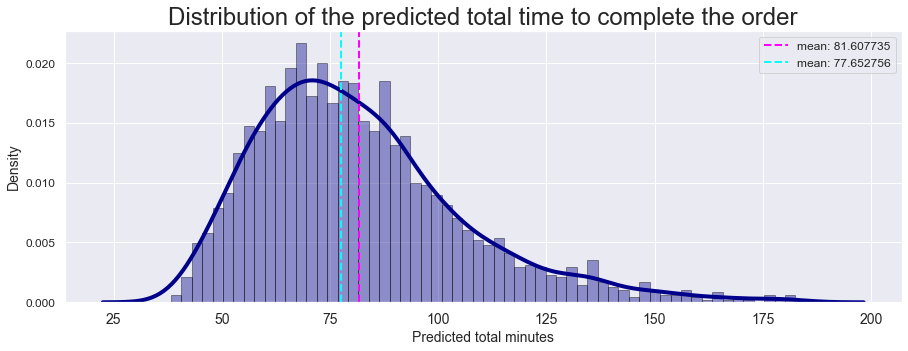

In [25]:
fig = plt.figure(figsize=(15,5))

ax = sns.distplot(df_pred.y_hat, hist=True, kde=True, 
         bins=int(180/3), color = 'darkblue', 
         hist_kws={'edgecolor':'black'},
         kde_kws={'linewidth': 4})

ax.axvline(df_pred.y_hat.mean(), 
           color='magenta', 
           linestyle='dashed', 
           linewidth=2, 
           label=f"mean: {str(df_pred.y_hat.mean().round(6))}")

ax.axvline(df_pred.y_hat.median(), 
           color='cyan', 
           linestyle='dashed', 
           linewidth=2, 
           label=f"mean: {str(df_pred.y_hat.median().round(6))}")

plt.title("Distribution of the predicted total time to complete the order")
plt.xlabel("Predicted total minutes")
plt.legend(loc='upper right')

del ax